In [1]:
from typing import Dict, List, Tuple, Union

import empyrical as ep
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from jqdata import *
from sqlalchemy.sql import func

plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

from scr import (
    PrepareData,
    TradeDays,
    get_author_proba,
    get_stock_group_returns,
    load_gold_stock_csv,
    transform2stock_group,
    view_author_stock,
)

td = TradeDays()

# 数据介绍

金股数据说明:end_date为金股的截至日(即券商推荐的金股有效期),write_date为公告日(即对应券商在微信公众号、研报等推送的时间),通过write_date我们可以看到金股组合大多数是在上月低和当月出发布出来。

**\统计分析时next_return使用的是$\frac{close}{close_{t-1}}-1$与end_date对齐的方式进行统计分析。**

In [2]:
# 获取金股数据
gold_stock_frame:pd.DataFrame = load_gold_stock_csv()
# 过滤北交所
cond = (gold_stock_frame['code'] != "835185.XSHG")
gold_stock_frame = gold_stock_frame[cond]
gold_stock_frame.head()

,author,sw_l3,org_name,code,end_date,write_date,sec_short_name
0,张云凯,住宅开发,东北证券,000656.XSHE,2018-01-31,2017-12-28,金科股份
1,李俊峰,种子,东北证券,000998.XSHE,2018-01-31,2017-12-28,隆平高科
2,李瑶,种子,东北证券,000998.XSHE,2018-01-31,2017-12-28,隆平高科
3,张云凯,商业地产,东北证券,001979.XSHE,2018-01-31,2017-12-28,招商蛇口
4,李恒光,底盘与发动机系统,东北证券,002126.XSHE,2018-01-31,2017-12-28,银轮股份


由下图可知道**平均write_date日在每月的第3-4个交易日即全部发布完毕,所以在回测时在每月的第三个交易日进行调仓轮动。**

平均在当月的第3.53发布


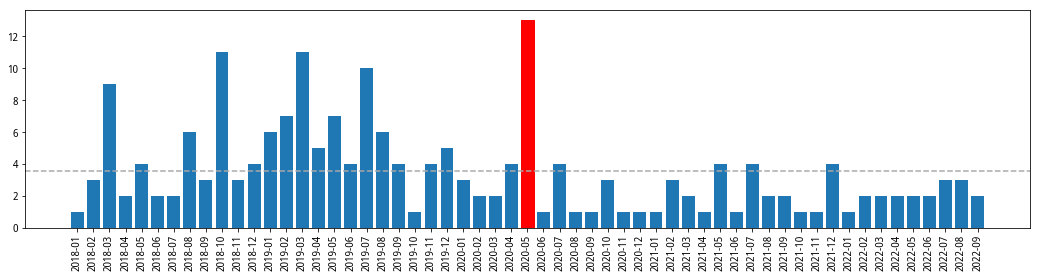

In [4]:
stats_write_date = gold_stock_frame.groupby('end_date')['write_date'].max()
stats_write_date = stats_write_date.to_frame()
stats_write_date.columns = ['write_date']
stats_write_date['DayOfMonth'] = stats_write_date['write_date'].apply(lambda x:td.tradeday_of_month(x))

stats_write_date.index = stats_write_date.index.strftime('%Y-%m')
fig,ax = plt.subplots(figsize=(18,4))
bar_ax = ax.bar(stats_write_date.index,stats_write_date['DayOfMonth'])

max_idx = stats_write_date.index.get_loc(stats_write_date['DayOfMonth'].idxmax())
bar_ax[max_idx].set_color('red')
avg_num:float = stats_write_date['DayOfMonth'].mean()
ax.axhline(avg_num,color='darkgray',ls='--')
plt.xticks(rotation=90);

print(f'平均在当月的第{round(avg_num,2)}发布')

# 金股推荐历史量化处理

使用Beta分布定量记录分析师金股推荐历史。假设，对于分析师的真实选股能力，没有先验知识。因此，每个分析师初始的Beta分布中，α = β = 1，此情况下，分析师推荐成功率在[0,1]上均匀分布。当分析师推荐金股成功时，即推荐月份的股票涨幅>0时，参数𝛼更新为𝛼 + 1。反之，当推荐失败时，参数𝛽更新为𝛽 + 1。

Beta 分布的期望:
$\mu=E(x)=\frac{\alpha}{\alpha+\beta}$

# 基于推荐成功概率分布构建金股组合

1. 股票池：当月所有券商推荐的金股，无其它筛选条件。
2. 组合构建流程：
    - 获取当月所有券商推荐的金股及推荐金股的分析师信息；
    - 查询金股数据库，获取当月推荐金股的每一位分析师的定量指标；
    - 对分析师定量指标进行排序，分为 5 组，并构建相应的 5 个等权金股组合；
    - 每月末重复上述操作并调仓；
    - 回测时段：2020 年 1 月至 2022 年 8 月
    - 调仓周期：月度调仓


In [6]:
# 获取初始数据
prepare_data = PrepareData(gold_stock_frame,'2017-12-01','2022-08-31')
prepare_data.init_data()
prepare_data.get_forward_returns()
all_data:pd.DataFrame = prepare_data.full_data()

# 获取分析师推荐概率
params:Dict = {
              'returns_name':'industry_excess', # 使用行业超额计算分析师推荐概率
              'window':12, # 分析师近window月有推荐股票且推荐次数不少于等于threshold次
              'threshold':5, 
              'beta_window':12 # beta分布滚动计算期
              }
author_proba:pd.DataFrame = get_author_proba(all_data,**params)
# 获取分析师组合
author_proflio:pd.DataFrame = transform2stock_group(author_proba,prepare_data.gold_stock_frame,group_num=5)
# 计算组合月度收益率
returns:pd.DataFrame =get_stock_group_returns(author_proflio,prepare_data.next_returns)

证券代码:000043.XSHE,2022-08-31未查询到sw_l1行业名称


<Figure size 1296x360 with 0 Axes>

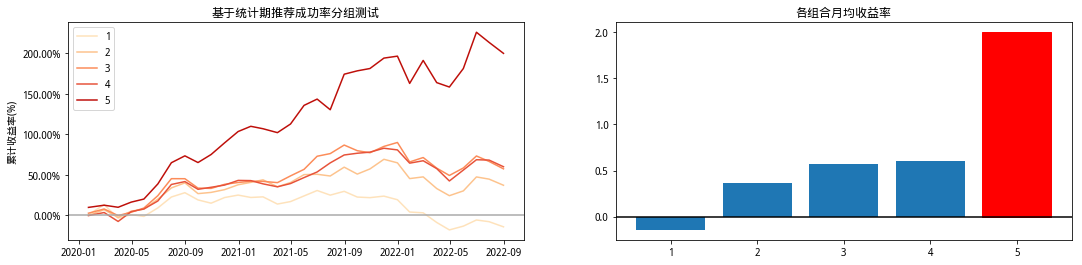

In [19]:
cum_frame = ep.cum_returns(returns.loc["2020-01-01":])
plt.figure(figsize=(18,5))

fig,axes = plt.subplots(1,2,figsize=(18,4))
bar_ax = axes[1].bar(cum_frame.iloc[-1].index,cum_frame.iloc[-1].values)
bar_ax[4].set_color('red')
axes[1].set_title('各组合月均收益率')
axes[0].set_title('基于统计期推荐成功率分组测试')
line_ax = sns.lineplot(data=cum_frame,palette='OrRd',dashes=False,ax=axes[0])

def mjrFormatter(x, pos):
    return "{0:.2f}%".format(x * 100)

line_ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(mjrFormatter))
line_ax.set_ylabel('累计收益率(%)')
axes[0].axhline(0,color='darkgray')
axes[1].axhline(0,color='black');

查看近期推荐概率top10的分析师及股票

In [20]:
top_author:pd.Series = author_proba.loc["2022-08-31"].nlargest(10)
top_author.name = ('2022-08-31',0)
top_author

monthEnd    author
2022-08-31  于芳博       0.714286
            张燕生       0.714286
            刘贵军       0.675000
            王楠        0.666667
            赵国防       0.616667
            鲍雁辛       0.611111
            黄涛        0.611111
            任文坡       0.605556
            陶贻功       0.604167
            李晓渊       0.600000
Name: (2022-08-31, 0), dtype: float64

In [21]:
view_author_stock(top_author,prepare_data.gold_stock_frame)

,author,sw_l3,org_name,code,end_date,write_date,sec_short_name,monthEnd
13084,陶贻功,其他专用设备,银河证券,002009.XSHE,2022-08-31,2022-07-28,天奇股份,2022-08-31
13087,任文坡,改性塑料,银河证券,002768.XSHE,2022-08-31,2022-07-28,国恩股份,2022-08-31
13182,王楠,通信终端及配件,兴业证券,003031.XSHE,2022-08-31,2022-07-30,中瓷电子,2022-08-31
13274,赵国防,啤酒,安信证券,600600.XSHG,2022-08-31,2022-08-01,青岛啤酒,2022-08-31
